In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(device)

cpu


In [2]:
np.random.seed(1)
n_points = 500
y = np.concatenate((np.zeros(n_points),np.ones(n_points),np.ones(n_points)*2,np.ones(n_points)*3,np.ones(n_points)*4,
                    np.ones(n_points)*5,np.ones(n_points)*6,np.ones(n_points)*7,np.ones(n_points)*8,np.ones(n_points)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [3]:
x = np.zeros((n_points*10,5))


np.random.seed(1)
cov_mat = [[0.02,0,0,0,0],[0,0.02,0,0,0],[0,0,0.02,0,0],
                                                 [0,0,0,0.02,0],[0,0,0,0,0.02]]

x[idx[0],:] = np.random.multivariate_normal(mean = [1,0,0,0,0],
                                            cov=cov_mat,size=sum(idx[0]))


x[idx[1],:] = np.random.multivariate_normal(mean = [0,1,0,0,0],
                                            cov=cov_mat,size=sum(idx[1]))


x[idx[2],:] = np.random.multivariate_normal(mean = [0,0,1,0,0],
                                            cov=cov_mat,size=sum(idx[2]))


x[idx[3],:] = np.random.multivariate_normal(mean = [0,0,0,-0.75,0.5],
                                            cov=cov_mat,size=sum(idx[3]))



x[idx[4],:] = np.random.multivariate_normal(mean = [0,0,0,0.65,-0.65],
                                            cov=cov_mat,size=sum(idx[4]))


x[idx[5],:] = np.random.multivariate_normal(mean = [0,0,0,-0.9,-0.75],
                                            cov=cov_mat,size=sum(idx[5]))


x[idx[6],:] = np.random.multivariate_normal(mean = [0,0,0,0.8,-0.8],
                                            cov=cov_mat,size=sum(idx[6]))

x[idx[7],:] = np.random.multivariate_normal(mean = [0,0,0,-0.5,0.8],
                                            cov=cov_mat,size=sum(idx[7]))


x[idx[8],:] = np.random.multivariate_normal(mean = [0,0,0,0.9,0.75],
                                            cov=cov_mat,size=sum(idx[8]))


x[idx[9],:] = np.random.multivariate_normal(mean = [0,0,0,-1,0.65],
                                            cov=cov_mat,size=sum(idx[9]))

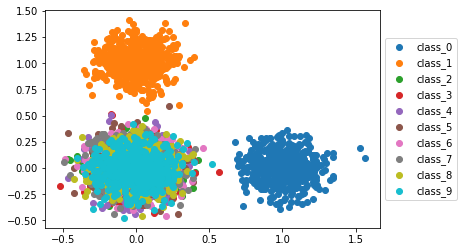

In [4]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
mean_x = np.mean(x,axis=0,keepdims=True)
std_x = np.std(x,axis=0,keepdims=True) 
x = ( x - mean_x  )  / std_x

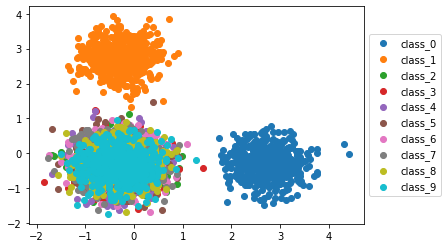

In [6]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [8]:
desired_num = 1100  # 2000 + 1000


m = 100



mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = 0#np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,5)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 1100/1100 [00:02<00:00, 392.36it/s]


In [12]:
def create_sin_data(mosaic_dataset,labels,fg_n,m):
  """
  mosaic_dataset : mosaic_dataset contains 500 patches of dimendion 2 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  """
  n_points = len(mosaic_dataset)
  patches = mosaic_dataset[0].shape[0]
  dims = mosaic_dataset[0].shape[1]
  img = np.zeros((n_points,patches,dims))

  for i in tqdm(range(len(mosaic_dataset))):
    for j in range(m):
      if j < fg_n:
        img[i][j] = mosaic_dataset[i][0]
      else:
        #print(j)
        index = np.random.randint(1,100,1)
        img[i][j]= mosaic_dataset[i][index]
    
    
  return  img,labels

In [13]:
tr = 100
avg_image_dataset_1 , labels_1 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],1,m)
avg_image_dataset_2 , labels_2 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],10,m)
avg_image_dataset_3 , labels_3 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],20,m)
avg_image_dataset_4, labels_4 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],30,m)
avg_image_dataset_5 , labels_5 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],40,m)
avg_image_dataset_6 , labels_6 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],50,m)
avg_image_dataset_7 , labels_7 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],60,m)
avg_image_dataset_8 , labels_8 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],70,m)
avg_image_dataset_9 , labels_9 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],80,m)
avg_image_dataset_10 , labels_10 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],90,m)
avg_image_dataset_11 , labels_11 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],100,m)
avg_image_dataset_12, labels_12 = create_sin_data(mosaic_list_of_images[tr:], mosaic_label[tr:],100,m)


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 15340.94it/s]


In [14]:
avg_image_dataset_1 = np.stack(avg_image_dataset_1)
avg_image_dataset_2 = np.stack(avg_image_dataset_2,axis=0)
avg_image_dataset_3 = np.stack(avg_image_dataset_3,axis=0)
avg_image_dataset_4 = np.stack(avg_image_dataset_4,axis=0)
avg_image_dataset_5 = np.stack(avg_image_dataset_5,axis=0)
avg_image_dataset_6 = np.stack(avg_image_dataset_6,axis=0)
avg_image_dataset_7 = np.stack(avg_image_dataset_7,axis=0)
avg_image_dataset_8 = np.stack(avg_image_dataset_8,axis=0)
avg_image_dataset_9 = np.stack(avg_image_dataset_9,axis=0)
avg_image_dataset_10 = np.stack(avg_image_dataset_10,axis=0)
avg_image_dataset_11 = np.stack(avg_image_dataset_11,axis=0)
avg_image_dataset_12 = np.stack(avg_image_dataset_12,axis=0)

In [15]:
avg_image_dataset_1.shape

(100, 100, 5)

In [16]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]

In [17]:
batch = 256


# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)


traindata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
trainloader_10 = DataLoader( traindata_10 , batch_size= batch ,shuffle=True)

traindata_11 = MosaicDataset(avg_image_dataset_11, labels_11)
trainloader_11 = DataLoader( traindata_11 , batch_size= batch ,shuffle=True)




testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)

testdata_11 = MosaicDataset(avg_image_dataset_11, labels_11 )
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)


testdata_12 = MosaicDataset(avg_image_dataset_12, labels_12 )
testloader_12 = DataLoader( testdata_12, batch_size= batch ,shuffle=False)






In [18]:
data,labels = iter(trainloader_1).next()

In [19]:
data.shape,labels.shape

(torch.Size([100, 100, 5]), torch.Size([100]))

In [20]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(5, 3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
  def forward(self, x):
    x = self.fc1(x)
    # print(x.shape)
    return x

In [21]:
def my_cross_entropy(output,target,loss_criterion):
    
    
    batch = output.size(0)
    #print(batch)
    patches = output.size(1)
    classes = output.size(2)
    output = torch.reshape(output,(batch*patches,classes))    
    target = target.repeat_interleave(patches)
    
    loss = loss_criterion(output,target)
    #print(final_loss)
    return loss

In [22]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    # out = []
    # pred = []
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device),labels.to(device)
            # out.append(labels.cpu().numpy())
            outputs= net(images)

            batch = outputs.size(0)
            #print(batch)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes)) 

            _, predicted = torch.max(outputs.data, 1)
            # pred.append(predicted.cpu().numpy())
            labels = labels.repeat_interleave(patches)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test dataset %d: %d %%' % (number , 100 * correct / total))

In [28]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    torch.manual_seed(12)
    net = Net().double()
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)#, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 300
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []
        running_loss = 0.0
        if epoch ==0:
            with torch.no_grad():
                for k, data in enumerate(trainloader, 0):
                    inputs, labels = data
                    inputs, labels = inputs.to(device),labels.to(device)
                    outputs = net(inputs)
                    loss = my_cross_entropy(outputs, labels,criterion)
                    running_loss += loss.item()
                    if k+1 ==8:
                        ep_lossi.append(running_loss/(k+1))
                        print('[%d, %5d] loss: %.3f' %(epoch, k+ 1, running_loss/(k+1) ))
                        running_loss = 0.0 
                        
                loss_curi.append(np.mean(ep_lossi))
                ep_lossi = []
                
                
            

        
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = my_cross_entropy(outputs, labels,criterion)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            mini = 1
            if i % mini == (mini-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / ( mini ) ))
                ep_lossi.append(running_loss/ (mini) ) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(np.mean(ep_lossi))   #loss per epoch
    print('Finished Training')
    torch.save(net.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            batch = outputs.size(0)
            #print(batch)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes)) 
            
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.repeat_interleave(patches)
            #print(predicted.shape,labels.shape,patches)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi


In [29]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10,testloader_11,testloader_12]
train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))
train_loss_all.append(train_all(trainloader_10, 10, testloader_list))
train_loss_all.append(train_all(trainloader_11, 11, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
[1,     1] loss: 3.181
[2,     1] loss: 1.575
[3,     1] loss: 1.560
[4,     1] loss: 1.545
[5,     1] loss: 1.531
[6,     1] loss: 1.517
[7,     1] loss: 1.503
[8,     1] loss: 1.490
[9,     1] loss: 1.477
[10,     1] loss: 1.465
[11,     1] loss: 1.453
[12,     1] loss: 1.441
[13,     1] loss: 1.429
[14,     1] loss: 1.418
[15,     1] loss: 1.407
[16,     1] loss: 1.397
[17,     1] loss: 1.386
[18,     1] loss: 1.376
[19,     1] loss: 1.366
[20,     1] loss: 1.356
[21,     1] loss: 1.347
[22,     1] loss: 1.338
[23,     1] loss: 1.328
[24,     1] loss: 1.319
[25,     1] loss: 1.311
[26,     1] loss: 1.302
[27,     1] loss: 1.294
[28,     1] loss: 1.286
[29,     1] loss: 1.278
[30,     1] loss: 1.270
[31,     1] loss: 1.263
[32,     1] loss: 1.255
[33,     1] loss: 1.248
[34,     1] loss: 1.241
[35,     1] loss: 1.235
[36,     1] loss: 1.228
[37,     1] loss: 1.222
[38,     1] los

[86,     1] loss: 1.044
[87,     1] loss: 1.043
[88,     1] loss: 1.043
[89,     1] loss: 1.042
[90,     1] loss: 1.041
[91,     1] loss: 1.040
[92,     1] loss: 1.040
[93,     1] loss: 1.039
[94,     1] loss: 1.038
[95,     1] loss: 1.038
[96,     1] loss: 1.037
[97,     1] loss: 1.037
[98,     1] loss: 1.036
[99,     1] loss: 1.036
[100,     1] loss: 1.035
[101,     1] loss: 1.035
[102,     1] loss: 1.035
[103,     1] loss: 1.034
[104,     1] loss: 1.034
[105,     1] loss: 1.034
[106,     1] loss: 1.033
[107,     1] loss: 1.033
[108,     1] loss: 1.033
[109,     1] loss: 1.033
[110,     1] loss: 1.032
[111,     1] loss: 1.032
[112,     1] loss: 1.032
[113,     1] loss: 1.032
[114,     1] loss: 1.031
[115,     1] loss: 1.031
[116,     1] loss: 1.031
[117,     1] loss: 1.031
[118,     1] loss: 1.031
[119,     1] loss: 1.031
[120,     1] loss: 1.030
[121,     1] loss: 1.030
[122,     1] loss: 1.030
[123,     1] loss: 1.030
[124,     1] loss: 1.030
[125,     1] loss: 1.030
[126,     1] l

[133,     1] loss: 0.938
[134,     1] loss: 0.937
[135,     1] loss: 0.937
[136,     1] loss: 0.937
[137,     1] loss: 0.937
[138,     1] loss: 0.937
[139,     1] loss: 0.937
[140,     1] loss: 0.936
[141,     1] loss: 0.936
[142,     1] loss: 0.936
[143,     1] loss: 0.936
[144,     1] loss: 0.936
[145,     1] loss: 0.936
[146,     1] loss: 0.936
[147,     1] loss: 0.936
[148,     1] loss: 0.935
[149,     1] loss: 0.935
[150,     1] loss: 0.935
[151,     1] loss: 0.935
[152,     1] loss: 0.935
[153,     1] loss: 0.935
[154,     1] loss: 0.935
[155,     1] loss: 0.935
[156,     1] loss: 0.935
[157,     1] loss: 0.935
[158,     1] loss: 0.935
[159,     1] loss: 0.935
[160,     1] loss: 0.934
[161,     1] loss: 0.934
[162,     1] loss: 0.934
[163,     1] loss: 0.934
[164,     1] loss: 0.934
[165,     1] loss: 0.934
[166,     1] loss: 0.934
[167,     1] loss: 0.934
[168,     1] loss: 0.934
[169,     1] loss: 0.934
[170,     1] loss: 0.934
[171,     1] loss: 0.934
[172,     1] loss: 0.934


[194,     1] loss: 0.835
[195,     1] loss: 0.834
[196,     1] loss: 0.834
[197,     1] loss: 0.834
[198,     1] loss: 0.834
[199,     1] loss: 0.834
[200,     1] loss: 0.834
[201,     1] loss: 0.834
[202,     1] loss: 0.834
[203,     1] loss: 0.834
[204,     1] loss: 0.834
[205,     1] loss: 0.834
[206,     1] loss: 0.834
[207,     1] loss: 0.834
[208,     1] loss: 0.834
[209,     1] loss: 0.834
[210,     1] loss: 0.834
[211,     1] loss: 0.834
[212,     1] loss: 0.834
[213,     1] loss: 0.834
[214,     1] loss: 0.834
[215,     1] loss: 0.834
[216,     1] loss: 0.834
[217,     1] loss: 0.834
[218,     1] loss: 0.834
[219,     1] loss: 0.833
[220,     1] loss: 0.833
[221,     1] loss: 0.833
[222,     1] loss: 0.833
[223,     1] loss: 0.833
[224,     1] loss: 0.833
[225,     1] loss: 0.833
[226,     1] loss: 0.833
[227,     1] loss: 0.833
[228,     1] loss: 0.833
[229,     1] loss: 0.833
[230,     1] loss: 0.833
[231,     1] loss: 0.833
[232,     1] loss: 0.833
[233,     1] loss: 0.833


[206,     1] loss: 0.733
[207,     1] loss: 0.733
[208,     1] loss: 0.732
[209,     1] loss: 0.732
[210,     1] loss: 0.732
[211,     1] loss: 0.732
[212,     1] loss: 0.732
[213,     1] loss: 0.732
[214,     1] loss: 0.732
[215,     1] loss: 0.732
[216,     1] loss: 0.732
[217,     1] loss: 0.732
[218,     1] loss: 0.732
[219,     1] loss: 0.732
[220,     1] loss: 0.732
[221,     1] loss: 0.731
[222,     1] loss: 0.731
[223,     1] loss: 0.731
[224,     1] loss: 0.731
[225,     1] loss: 0.731
[226,     1] loss: 0.731
[227,     1] loss: 0.731
[228,     1] loss: 0.731
[229,     1] loss: 0.731
[230,     1] loss: 0.731
[231,     1] loss: 0.731
[232,     1] loss: 0.731
[233,     1] loss: 0.731
[234,     1] loss: 0.731
[235,     1] loss: 0.731
[236,     1] loss: 0.731
[237,     1] loss: 0.731
[238,     1] loss: 0.731
[239,     1] loss: 0.730
[240,     1] loss: 0.730
[241,     1] loss: 0.730
[242,     1] loss: 0.730
[243,     1] loss: 0.730
[244,     1] loss: 0.730
[245,     1] loss: 0.730


[218,     1] loss: 0.623
[219,     1] loss: 0.623
[220,     1] loss: 0.623
[221,     1] loss: 0.623
[222,     1] loss: 0.622
[223,     1] loss: 0.622
[224,     1] loss: 0.622
[225,     1] loss: 0.622
[226,     1] loss: 0.622
[227,     1] loss: 0.622
[228,     1] loss: 0.622
[229,     1] loss: 0.622
[230,     1] loss: 0.622
[231,     1] loss: 0.622
[232,     1] loss: 0.621
[233,     1] loss: 0.621
[234,     1] loss: 0.621
[235,     1] loss: 0.621
[236,     1] loss: 0.621
[237,     1] loss: 0.621
[238,     1] loss: 0.621
[239,     1] loss: 0.621
[240,     1] loss: 0.621
[241,     1] loss: 0.621
[242,     1] loss: 0.621
[243,     1] loss: 0.621
[244,     1] loss: 0.620
[245,     1] loss: 0.620
[246,     1] loss: 0.620
[247,     1] loss: 0.620
[248,     1] loss: 0.620
[249,     1] loss: 0.620
[250,     1] loss: 0.620
[251,     1] loss: 0.620
[252,     1] loss: 0.620
[253,     1] loss: 0.620
[254,     1] loss: 0.620
[255,     1] loss: 0.620
[256,     1] loss: 0.620
[257,     1] loss: 0.620


[235,     1] loss: 0.512
[236,     1] loss: 0.512
[237,     1] loss: 0.512
[238,     1] loss: 0.512
[239,     1] loss: 0.512
[240,     1] loss: 0.512
[241,     1] loss: 0.512
[242,     1] loss: 0.512
[243,     1] loss: 0.511
[244,     1] loss: 0.511
[245,     1] loss: 0.511
[246,     1] loss: 0.511
[247,     1] loss: 0.511
[248,     1] loss: 0.511
[249,     1] loss: 0.511
[250,     1] loss: 0.511
[251,     1] loss: 0.511
[252,     1] loss: 0.511
[253,     1] loss: 0.510
[254,     1] loss: 0.510
[255,     1] loss: 0.510
[256,     1] loss: 0.510
[257,     1] loss: 0.510
[258,     1] loss: 0.510
[259,     1] loss: 0.510
[260,     1] loss: 0.510
[261,     1] loss: 0.510
[262,     1] loss: 0.510
[263,     1] loss: 0.509
[264,     1] loss: 0.509
[265,     1] loss: 0.509
[266,     1] loss: 0.509
[267,     1] loss: 0.509
[268,     1] loss: 0.509
[269,     1] loss: 0.509
[270,     1] loss: 0.509
[271,     1] loss: 0.509
[272,     1] loss: 0.509
[273,     1] loss: 0.509
[274,     1] loss: 0.509


[245,     1] loss: 0.401
[246,     1] loss: 0.401
[247,     1] loss: 0.401
[248,     1] loss: 0.400
[249,     1] loss: 0.400
[250,     1] loss: 0.400
[251,     1] loss: 0.400
[252,     1] loss: 0.400
[253,     1] loss: 0.400
[254,     1] loss: 0.400
[255,     1] loss: 0.399
[256,     1] loss: 0.399
[257,     1] loss: 0.399
[258,     1] loss: 0.399
[259,     1] loss: 0.399
[260,     1] loss: 0.399
[261,     1] loss: 0.399
[262,     1] loss: 0.399
[263,     1] loss: 0.399
[264,     1] loss: 0.398
[265,     1] loss: 0.398
[266,     1] loss: 0.398
[267,     1] loss: 0.398
[268,     1] loss: 0.398
[269,     1] loss: 0.398
[270,     1] loss: 0.398
[271,     1] loss: 0.398
[272,     1] loss: 0.398
[273,     1] loss: 0.397
[274,     1] loss: 0.397
[275,     1] loss: 0.397
[276,     1] loss: 0.397
[277,     1] loss: 0.397
[278,     1] loss: 0.397
[279,     1] loss: 0.397
[280,     1] loss: 0.397
[281,     1] loss: 0.397
[282,     1] loss: 0.397
[283,     1] loss: 0.397
[284,     1] loss: 0.396


[256,     1] loss: 0.279
[257,     1] loss: 0.279
[258,     1] loss: 0.279
[259,     1] loss: 0.279
[260,     1] loss: 0.279
[261,     1] loss: 0.279
[262,     1] loss: 0.278
[263,     1] loss: 0.278
[264,     1] loss: 0.278
[265,     1] loss: 0.278
[266,     1] loss: 0.278
[267,     1] loss: 0.278
[268,     1] loss: 0.277
[269,     1] loss: 0.277
[270,     1] loss: 0.277
[271,     1] loss: 0.277
[272,     1] loss: 0.277
[273,     1] loss: 0.277
[274,     1] loss: 0.277
[275,     1] loss: 0.276
[276,     1] loss: 0.276
[277,     1] loss: 0.276
[278,     1] loss: 0.276
[279,     1] loss: 0.276
[280,     1] loss: 0.276
[281,     1] loss: 0.276
[282,     1] loss: 0.275
[283,     1] loss: 0.275
[284,     1] loss: 0.275
[285,     1] loss: 0.275
[286,     1] loss: 0.275
[287,     1] loss: 0.275
[288,     1] loss: 0.275
[289,     1] loss: 0.275
[290,     1] loss: 0.274
[291,     1] loss: 0.274
[292,     1] loss: 0.274
[293,     1] loss: 0.274
[294,     1] loss: 0.274
[295,     1] loss: 0.274


[281,     1] loss: 0.160
[282,     1] loss: 0.160
[283,     1] loss: 0.160
[284,     1] loss: 0.160
[285,     1] loss: 0.159
[286,     1] loss: 0.159
[287,     1] loss: 0.159
[288,     1] loss: 0.159
[289,     1] loss: 0.159
[290,     1] loss: 0.159
[291,     1] loss: 0.158
[292,     1] loss: 0.158
[293,     1] loss: 0.158
[294,     1] loss: 0.158
[295,     1] loss: 0.158
[296,     1] loss: 0.158
[297,     1] loss: 0.158
[298,     1] loss: 0.157
[299,     1] loss: 0.157
[300,     1] loss: 0.157
Finished Training
Accuracy of the network on the train images: 93 %
Accuracy of the network on the test dataset 1: 35 %
Accuracy of the network on the test dataset 2: 40 %
Accuracy of the network on the test dataset 3: 47 %
Accuracy of the network on the test dataset 4: 54 %
Accuracy of the network on the test dataset 5: 60 %
Accuracy of the network on the test dataset 6: 67 %
Accuracy of the network on the test dataset 7: 74 %
Accuracy of the network on the test dataset 8: 80 %
Accuracy of the 

[294,     1] loss: 0.039
[295,     1] loss: 0.038
[296,     1] loss: 0.038
[297,     1] loss: 0.038
[298,     1] loss: 0.038
[299,     1] loss: 0.038
[300,     1] loss: 0.037
Finished Training
Accuracy of the network on the train images: 100 %
Accuracy of the network on the test dataset 1: 35 %
Accuracy of the network on the test dataset 2: 41 %
Accuracy of the network on the test dataset 3: 47 %
Accuracy of the network on the test dataset 4: 54 %
Accuracy of the network on the test dataset 5: 61 %
Accuracy of the network on the test dataset 6: 67 %
Accuracy of the network on the test dataset 7: 73 %
Accuracy of the network on the test dataset 8: 80 %
Accuracy of the network on the test dataset 9: 87 %
Accuracy of the network on the test dataset 10: 93 %
Accuracy of the network on the test dataset 11: 100 %
Accuracy of the network on the test dataset 12: 100 %
--------------------------------------------------------------------------------


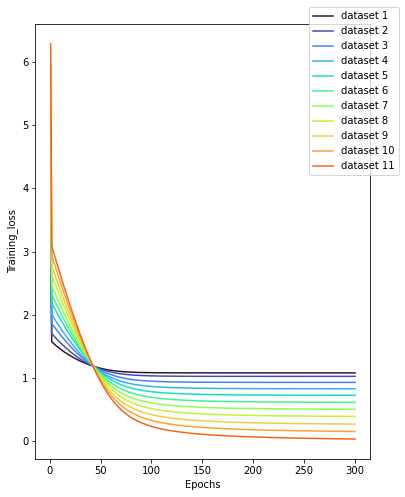

In [30]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(train_loss_all):
   plt.plot(j,label ="dataset "+str(i+1),color = cm(i*20))
plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))